In [79]:
import pandas as pd
import deepxde as dde
import numpy as np
import re
import matplotlib.pyplot as plt

In [80]:
H = dde.Variable(1.6)
D = dde.Variable(0.2)

In [81]:
# '''
# 24th July, 2023 created by Likun Chen, Wuhan University
# This is for testing the PINN parameter estimation, object: syn-machine
# EXT Parameters:
#     Vi , initial terminal voltage : 1.0 pu
#     Ta , voltage regulator time constant : 0.4 sec
#     Kf , rate feedback gain : 0.03
# SYN Parameters:
#     H , inertia constant : 1.7 MWs/MVA
#     D , synchronous mechanical damping : 0.12 pu/pu
#     Xa , stator leakage reactance : 0.130 pu
#     Xd , d-axis unsaturated reactance : 1.79 pu
#     Xd' , d-axis unsaturated transient reactance : 0.169 pu
#     Xd'' , d-axis unsaturated Sub-Trans reactance : 0.135 pu
#     Xq , q-axis unsaturated reactance : 1.71 pu
#     Xq' , q-axis unsaturated transient reactance : 0.228 pu
#     Xq'' , q-axis unsaturated Sub-Trans reactance : 0.2 pu
# For 2-order equation, the state variables are rev (w) and phase angle (delta), 
# parameters waiting estimated are H , D , Eq' = Ed' = const
#     H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
#     P_ex is external power balance and P_mach is the mechanical power
#     time， P_ex, delta, P_mach, dw
# '''

In [82]:
input_data = pd.read_csv('data/927testforTe2.csv')
input_data

,Time,Subsystem #1|CTLs|Vars|Tm,Subsystem #1|Machines|M|TESTSPDOUT,Subsystem #1|Machines|M|TESTTELECT
0,0.00000,0.000000,1.005288,3.309534e-08
1,0.00005,0.000000,1.005288,3.263598e-08
2,0.00010,0.000000,1.005288,3.258290e-08
3,0.00015,0.000000,1.005288,3.293628e-08
4,0.00020,0.000000,1.005288,3.369583e-08
...,...,...,...,...
7995,0.39975,0.914581,0.970005,6.204557e-01
7996,0.39980,0.914565,0.970010,6.204525e-01
7997,0.39985,0.914550,0.970015,6.204492e-01
7998,0.39990,0.914534,0.970020,6.204459e-01


In [83]:
step_time = input_data.Time[1] - input_data.Time[0]
st = 0.5 # start time (10% proportion)
et = 1 # end time
input_data.Time -= step_time * int(input_data.shape[0] * st)
input_data = input_data[int(input_data.shape[0]*st): int(input_data.shape[0]*et)]

In [84]:
input_data.set_index('Time', inplace=True)

In [85]:
input_data.columns=['Tm','w', 'Te']

<Axes: xlabel='Time'>

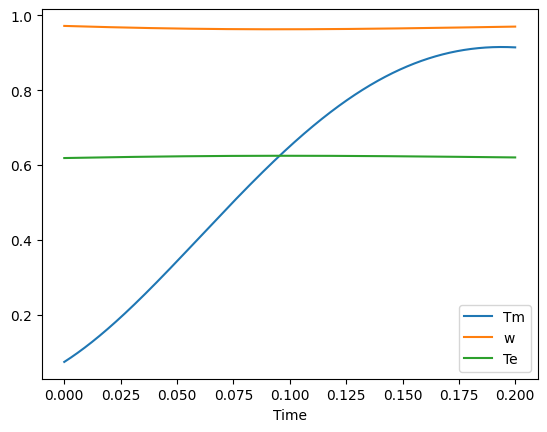

In [86]:
input_data.plot()

In [87]:
x = input_data.index.to_numpy()
x

array([0.0000e+00, 5.0000e-05, 1.0000e-04, ..., 1.9985e-01, 1.9990e-01,
       1.9995e-01])

In [88]:
geom = dde.geometry.TimeDomain(0, x[-1])

In [89]:
def boundary(_, on_initial):
    return on_initial

In [90]:
x0 = input_data.iloc[0].tolist()

In [91]:
# Initial conditions
ic1 = dde.icbc.IC(geom, lambda X: x0[0], boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: x0[1], boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: x0[2], boundary, component=2)

In [92]:
y = input_data.to_numpy()
y.shape

(4000, 3)

In [93]:
observe_t = x.reshape(-1, 1)

In [94]:
# Get the training data
observe_y0 = dde.icbc.PointSetBC(observe_t, y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, y[:, 2:3], component=2)

In [95]:
# H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
def Microgrid_system(x, y):
    """Modified Lorenz system (with exogenous input).
    H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
    """
    Tm, w, Te = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dw_dt = dde.grad.jacobian(y, x, i=1)
    return [
        Tm-Te - 2*H*dw_dt - D*(w-1)
    ]


In [96]:
# class ex_func2():
#     def __init__(self, input_data):
#         self.input_data = input_data
#     def fun(self, t):
#         t = t.reshape(-1, )
#         return self.input_data.iloc[t]['Subsystem #1|CTLs|Vars|PGEN'].to_numpy().reshape(-1, 1)

In [97]:
data = dde.data.PDE(
    geom,
    Microgrid_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    # num_domain=800,
    # num_boundary=3,
    anchors=observe_t,
#     auxiliary_var_function=ex_func2(input_data).fun,
)

In [98]:
net = dde.nn.FNN([1] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[H, D])



Compiling model...
Building feed-forward neural network...
'build' took 0.027975 s



C:\env\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.257173 s



In [99]:
fnamevar = "variables_testclk1.dat"
variable = dde.callbacks.VariableValue([H, D], period=200, filename=fnamevar)
model.train(iterations=5000000, callbacks=[variable])

Initializing variables...
Training model...

0         [8.94e-02, 5.48e-03, 9.44e-01, 3.83e-01, 4.02e-01, 9.40e-01, 3.37e-01]    [8.94e-02, 5.48e-03, 9.44e-01, 3.83e-01, 4.02e-01, 9.40e-01, 3.37e-01]    []  
1000      [2.17e-05, 3.32e-05, 2.04e-08, 7.44e-07, 2.27e-03, 2.23e-07, 3.06e-06]    [2.17e-05, 3.32e-05, 2.04e-08, 7.44e-07, 2.27e-03, 2.23e-07, 3.06e-06]    []  
2000      [2.58e-05, 2.24e-05, 1.44e-07, 7.06e-07, 2.06e-03, 3.33e-07, 2.65e-06]    [2.58e-05, 2.24e-05, 1.44e-07, 7.06e-07, 2.06e-03, 3.33e-07, 2.65e-06]    []  
3000      [3.84e-05, 6.94e-06, 7.14e-07, 5.43e-07, 1.66e-03, 1.09e-06, 1.68e-06]    [3.84e-05, 6.94e-06, 7.14e-07, 5.43e-07, 1.66e-03, 1.09e-06, 1.68e-06]    []  
4000      [6.50e-05, 4.85e-06, 2.17e-06, 1.66e-08, 9.75e-04, 4.51e-06, 1.34e-07]    [6.50e-05, 4.85e-06, 2.17e-06, 1.66e-08, 9.75e-04, 4.51e-06, 1.34e-07]    []  
5000      [5.53e-05, 2.83e-05, 3.70e-06, 2.34e-07, 8.06e-04, 6.29e-06, 1.48e-06]    [5.53e-05, 2.83e-05, 3.70e-06, 2.34e-07, 8.06e-04, 6.29e

KeyboardInterrupt: 

In [100]:
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar (this line is a long story...)
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

In [101]:
Chat.shape

(15746, 2)

Text(0.5, 0, 'Epoch')

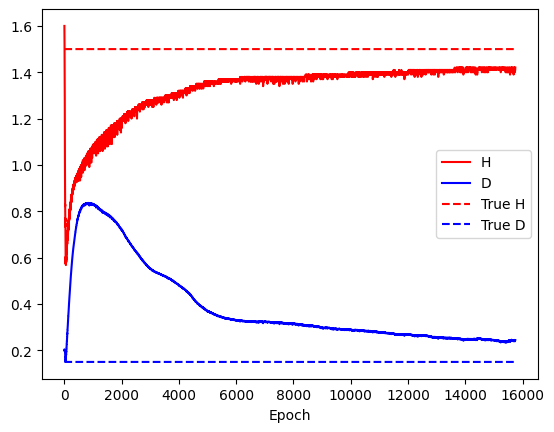

In [102]:
l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-")
plt.plot(range(l), Chat[:, 1], "b-")
plt.plot(range(l), np.ones(Chat[:, 0].shape) * 1.5, "r--")
plt.plot(range(l), np.ones(Chat[:, 1].shape) * 0.15, "b--")
plt.legend(["H","D","True H","True D"], loc="right")
plt.xlabel("Epoch")

In [111]:
# pd.Series((input_data.Tm - input_data.Te).to_numpy()[1:] / ((input_data.w.to_numpy()[1:] - input_data.w.to_numpy()[:-1]) / (input_data.index[1] - input_data.index[0])) / 2).plot()
Chat[-10:, 0:2]

array([[1.41 , 0.242],
       [1.41 , 0.243],
       [1.41 , 0.243],
       [1.41 , 0.243],
       [1.41 , 0.243],
       [1.41 , 0.243],
       [1.41 , 0.243],
       [1.42 , 0.243],
       [1.42 , 0.244],
       [1.42 , 0.244]])

In [104]:
input_data

,Tm,w,Te
Time,,,
0.00000,0.074038,0.971837,0.618821
0.00005,0.074231,0.971828,0.618826
0.00010,0.074424,0.971819,0.618832
0.00015,0.074617,0.971810,0.618837
0.00020,0.074810,0.971801,0.618843
...,...,...,...
0.19975,0.914581,0.970005,0.620456
0.19980,0.914565,0.970010,0.620452
0.19985,0.914550,0.970015,0.620449


In [ ]:
(2*1.5*(((input_data.w.to_numpy()[1:] - input_data.w.to_numpy()[:-1]) / (input_data.index[1] - input_data.index[0])) / 2)).shape

In [ ]:
input_data

In [ ]:
pd.Series((input_data.Te - input_data.Te).to_numpy()[1:] - 2*1.5*(((input_data.w.to_numpy()[1:] - input_data.w.to_numpy()[:-1]) / (input_data.index[1] - input_data.index[0])) / 2) - 0.15*(input_data.w.to_numpy()[1:]-1)).plot()

In [ ]:
pd.Series((input_data.Tm - input_data.Te).to_numpy()[1:] - 2*1.5*(((input_data.w.to_numpy()[1:] - input_data.w.to_numpy()[:-1]) / (input_data.index[1] - input_data.index[0])) / 2) + 0.15*(input_data.w.to_numpy()[1:]-1))

In [ ]:
pd.Series((input_data.Tm - input_data.Te).to_numpy()[1:] - 2*1.5*(((input_data.w.to_numpy()[1:] - input_data.w.to_numpy()[:-1]) / (input_data.index[1] - input_data.index[0])) / 2) - 0.15*(input_data.w.to_numpy()[1:]-1)).plot()

In [ ]:
yhat = model.predict(observe_t)
plt.figure()
plt.plot(observe_t, y, "-", observe_t, yhat, "--")
plt.xlabel("Time")
# plt.legend(["x", "y", "z", "xh", "yh", "zh"])
# plt.title("Training data")
plt.show()